In [1]:
from psa import Strategy, Disease, Psa, Icer
from load_data import data_loader

In [2]:
!ls ../data/

'CI-13052022 - Coppie.xlsx'		   'Dati Input Strategies_custom.xlsx'
'Dati Input Costs.xlsx'			   'Dati Input Strategies.xlsx'
'Dati Input Disease_betathalassemia.xlsx'  'Dati Input.xlsx'
'Dati Input Disease.xlsx'


In [3]:
import os

#file_disease = '../data/Dati Input Disease.xlsx'
#file_strategies = '../data/Dati Input Strategies.xlsx'
#file_costs = '../data/Dati Input Costs.xlsx'
#out_folder = '../output/igenomix_af'

file_disease = '../data/Dati Input Disease_betathalassemia.xlsx'
file_strategies = '../data/Dati Input Strategies.xlsx'
file_costs = '../data/Dati Input Costs.xlsx'
out_folder = '../output/betathalassemia'


os.makedirs('../output',exist_ok=True)
os.makedirs(out_folder,exist_ok=True)

# Toy data

In [4]:
# Disease Definitions
d1 = Disease(name='disease1',carrier_rate=0.01,life_expectancy=80,cost=10000)
d2 = Disease(name='disease2',carrier_rate=0.02,life_expectancy=60,cost=20000)
d3 = Disease(name='disease3',carrier_rate=0.005,life_expectancy=40,cost=100000)
disease_dict_fake = {'disease1':d1,'disease2':d2,'disease3':d3}


# Strategies Definition
s0 = Strategy('No testing',disease_list=[],testing_cost=0,disease_dict=disease_dict_fake)
s1 = Strategy('Limited screening',disease_list=['disease2'],testing_cost=1000,disease_dict=disease_dict_fake)
s2 = Strategy('Full screening',disease_list=['disease1','disease2','disease3'],testing_cost=1200,disease_dict=disease_dict_fake)

strategy_dict_fake = {'s0':s0,'s1':s1,'s2':s2}




In [5]:
s0.assess_strategy(disease_space=['disease1','disease2','disease3'])

{'p_affected_total': 0.00013125,
 'life_exp': 82.99735624999998,
 'total_cost': 2.875}

In [6]:
icer1 = Icer(s2,s1)
icer1.compute_icer()
display(icer1.icer)
display(icer1.delta_years)
display(icer1.delta_costs)

785331.5958672068

0.0002542058750094611

199.6359054999998

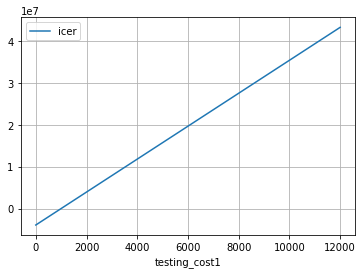

In [7]:
icer1.univariate_sensitivity('testing_cost1',0,12000,50)
icer1.plot_sensitivity()

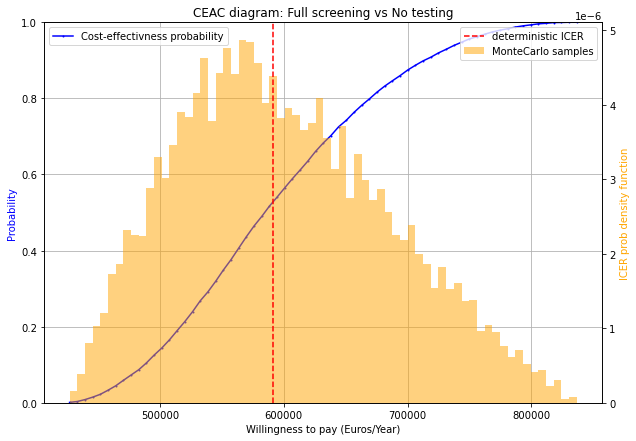

In [8]:
psa = Psa(s2,s0)
psa.run_mc(disease_space=['disease1','disease2','disease3'],
    intervention_cost_lb=2000, intervention_cost_ub=3000,
       testing_cost1_lb=1000, testing_cost1_ub=1300,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)

psa.plot_ceac_hist()

# Load real data

In [9]:


dl = data_loader(file_disease,file_strategies,file_costs=file_costs)



In [10]:
dl.disease_dict['Beta Thalassemia'].__str__()

'Beta Thalassemia'

In [11]:
dl.disease_dict['Beta Thalassemia']

Disease: Beta Thalassemia

In [12]:
for strategy in dl.strategy_dict.keys():

    display(strategy,
            dl.strategy_dict[strategy].assess_strategy(intervention_cost=19714,eps_cs=0,eps_pgt=0))

'Strategy D (ACMG)'

{'p_affected_total': 0.00010593820861677995,
 'life_exp': 82.99554244614512,
 'total_cost': 701.3618980300449}

'Strategy A1 (MS)'

{'p_affected_total': 0.0005504975994758128,
 'life_exp': 82.99491476425194,
 'total_cost': 892.6709264692682}

'Strategy A2 (FS)'

{'p_affected_total': 0.002934852159509895,
 'life_exp': 82.99239695571221,
 'total_cost': 1903.246092046443}

'Strategy C (ACOG)'

{'p_affected_total': 8.98597812921938e-05,
 'life_exp': 82.99621861912722,
 'total_cost': 287.2285791298061}

'No testing'

{'p_affected_total': 0, 'life_exp': 83, 'total_cost': 0}

# cost effectivness plane

In [13]:
dl.strategy_dict.keys()

dict_keys(['Strategy D (ACMG)', 'Strategy A1 (MS)', 'Strategy A2 (FS)', 'Strategy C (ACOG)', 'No testing'])

In [14]:
import pandas as pd
df_icer = pd.DataFrame()

for comparison in [('Strategy A1 (MS)','No testing'),
                  ('Strategy A2 (FS)','No testing'),
                  ('Strategy A1 (MS)','Strategy C (ACOG)'),
                  ('Strategy A1 (MS)','Strategy D (ACMG)'),
                  ('Strategy A2 (FS)','Strategy C (ACOG)'),
                  ('Strategy A2 (FS)','Strategy D (ACMG)'),
                  ('Strategy A2 (FS)','Strategy A1 (MS)')
                  ]:
    strategy1 = comparison[0]
    strategy2 = comparison[1]

    icer1 = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                 eps_cs=0,eps_pgt=0,intervention_cost=19714)
    icer1.compute_icer()
    #display(icer1.disease_space)
    df_icer = df_icer.append(
        {'strategy1':strategy1,'strategy2':strategy2,
           'icer':icer1.icer,
           'total cost1':icer1.total_cost1,
           'total cost2':icer1.total_cost2,
           'life exp1':icer1.life_exp1,
           'life exp2':icer1.life_exp2,
          'benefit difference (years)':icer1.life_exp1-icer1.life_exp2,
        'cost difference (Euros)':icer1.total_cost1-icer1.total_cost2},ignore_index=True)

df_icer['cfr'] = df_icer['strategy1']+' vs '+df_icer['strategy2']

In [15]:
df_icer.columns

Index(['benefit difference (years)', 'cost difference (Euros)', 'icer',
       'life exp1', 'life exp2', 'strategy1', 'strategy2', 'total cost1',
       'total cost2', 'cfr'],
      dtype='object')

In [16]:


df_icer

,benefit difference (years),cost difference (Euros),icer,life exp1,life exp2,strategy1,strategy2,total cost1,total cost2,cfr
0,0.017024,-1313.162406,-77133.752593,82.994915,82.977890,Strategy A1 (MS),No testing,892.670926,2205.833332,Strategy A1 (MS) vs No testing
1,0.025454,-1829.172825,-71862.832533,82.992397,82.966943,Strategy A2 (FS),No testing,1903.246092,3732.418917,Strategy A2 (FS) vs No testing
2,0.004365,-1237.321678,-283459.148003,82.994915,82.990550,Strategy A1 (MS),Strategy C (ACOG),892.670926,2129.992604,Strategy A1 (MS) vs Strategy C (ACOG)
3,0.002101,130.669680,62183.095444,82.994915,82.992813,Strategy A1 (MS),Strategy D (ACMG),892.670926,762.001247,Strategy A1 (MS) vs Strategy D (ACMG)
4,0.012794,-1753.332097,-137040.476234,82.992397,82.979603,Strategy A2 (FS),Strategy C (ACOG),1903.246092,3656.578189,Strategy A2 (FS) vs Strategy C (ACOG)
5,0.010531,-385.340739,-36592.633712,82.992397,82.981866,Strategy A2 (FS),Strategy D (ACMG),1903.246092,2288.586831,Strategy A2 (FS) vs Strategy D (ACMG)
6,0.008429,-516.010419,-61217.117941,82.992397,82.983968,Strategy A2 (FS),Strategy A1 (MS),1903.246092,2419.256511,Strategy A2 (FS) vs Strategy A1 (MS)


In [17]:
df_icer[['strategy1','strategy2','icer','benefit difference (years)', 'cost difference (Euros)','life exp1', 'life exp2','total cost1',
       'total cost2']].to_excel(os.path.join(out_folder,'icer.xlsx'))

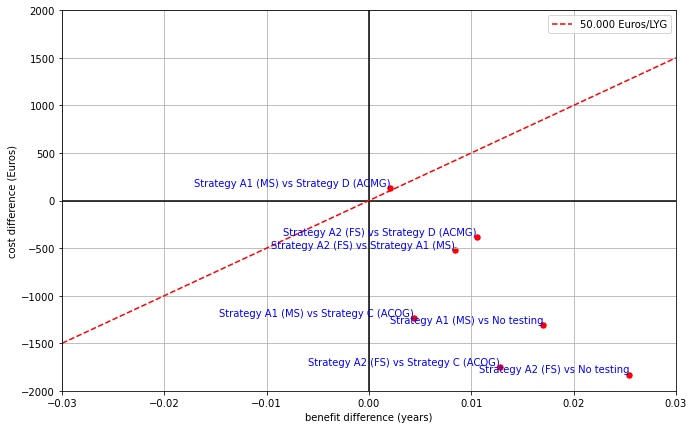

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(11,7))

sns.scatterplot(ax=ax,data = df_icer,x='benefit difference (years)',y='cost difference (Euros)',color='r',s=50)

plt.axhline(0,c='k')
plt.axvline(0,c='k')
plt.xlim([-0.03,0.03])
plt.ylim([-2000,2000])

icer_th = 50000
x1 = -0.03
x2 = 0.03
plt.plot([x1,x2],[x1*icer_th,x2*icer_th],ls='--',c='r',label='50.000 Euros/LYG')

for line in range(0,df_icer.shape[0]):
     plt.text(df_icer['benefit difference (years)'][line],
              df_icer['cost difference (Euros)'][line], 
              df_icer['cfr'][line], horizontalalignment='right', verticalalignment='bottom', size='medium', color='blue')#, weight='semibold')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_folder,'cost_effectivness_plane.jpeg'))

# Sensitivity analysis

In [19]:
import pandas as pd
df_icer_sensitivity = pd.DataFrame()

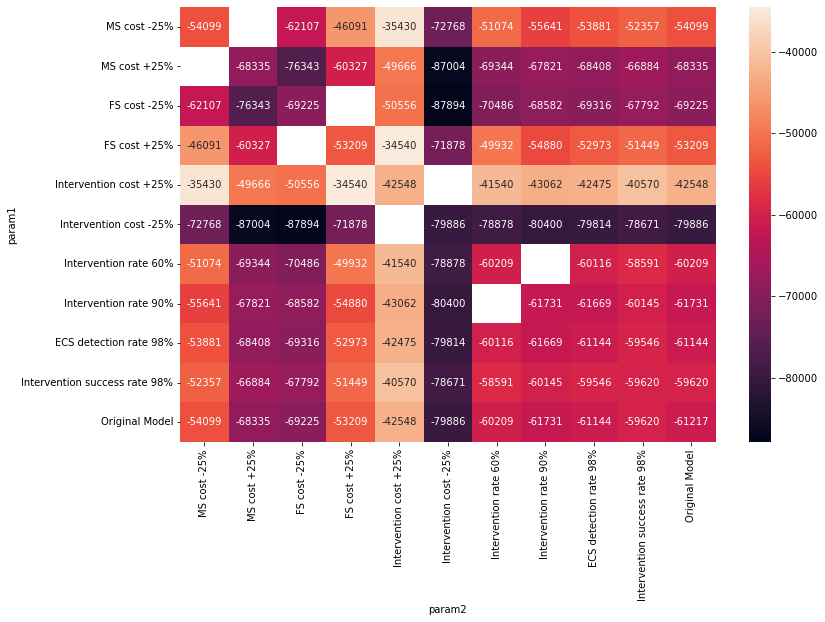

In [20]:
# FS vs MS 

intervention_cost = 19714
rho_notint = 0.23
MS_cost = dl.strategy_dict['Strategy A1 (MS)'].testing_cost
FS_cost = dl.strategy_dict['Strategy A2 (FS)'].testing_cost


strategy1 = 'Strategy A2 (FS)'
strategy2 = 'Strategy A1 (MS)'


param_list = [
    ('testing_cost2',0.75*MS_cost,'MS cost -25%'),
              ('testing_cost2',1.25*MS_cost,'MS cost +25%'),
              ('testing_cost1',0.75*FS_cost,'FS cost -25%'),
              ('testing_cost1',1.25*FS_cost,'FS cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]

df_icer_sensitivity = pd.DataFrame()

for param1 in param_list:
    for param2 in param_list:
        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:

            #print(param1,param2)

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

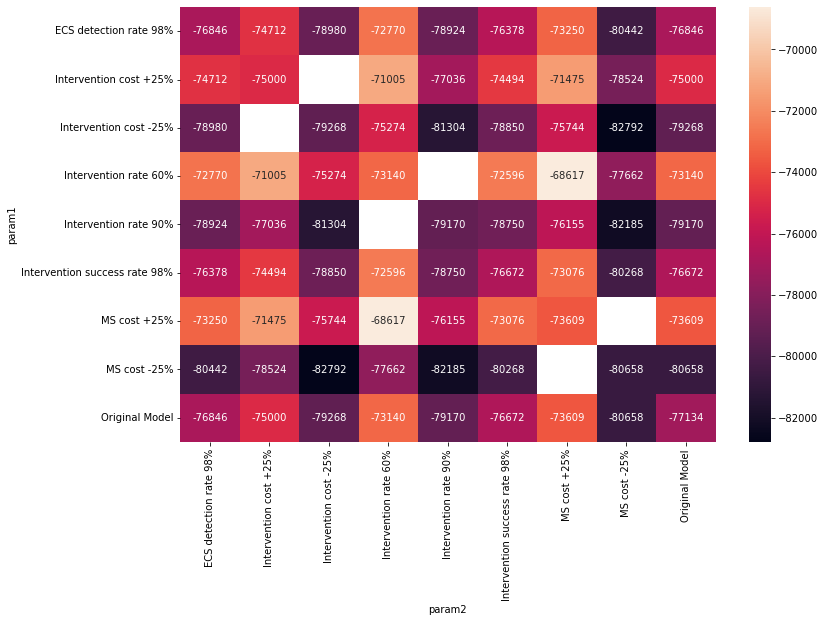

In [21]:
# MS vs no testing


intervention_cost = 19714
rho_notint = 0.23
MS_cost = dl.strategy_dict['Strategy A1 (MS)'].testing_cost


strategy1 = 'Strategy A1 (MS)'
strategy2 = 'No testing'

param_list = [
    ('testing_cost1',0.75*MS_cost,'MS cost -25%'),
              ('testing_cost1',1.25*MS_cost,'MS cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)

        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        
        
            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

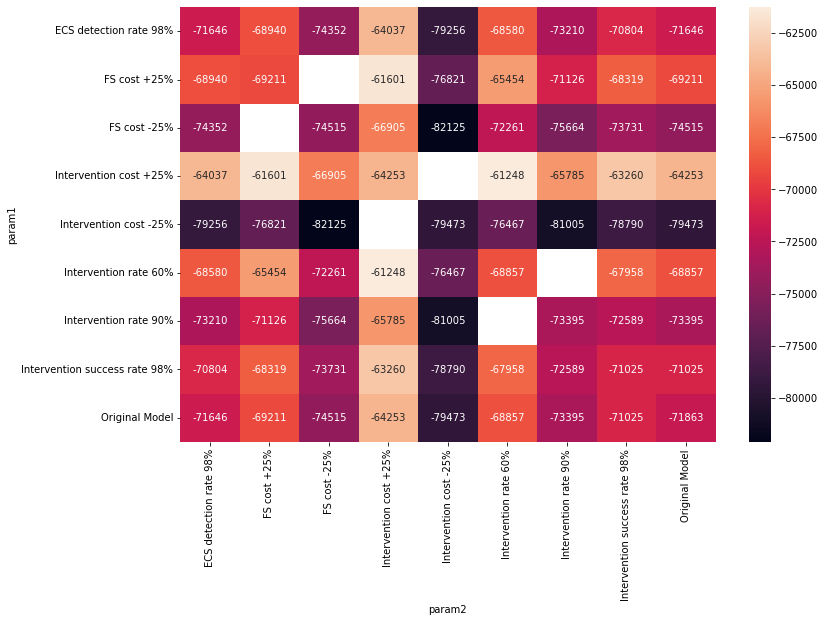

In [22]:
# FS vs no testing


intervention_cost = 19714
rho_notint = 0.23
MS_cost = dl.strategy_dict['Strategy A1 (MS)'].testing_cost


strategy1 = 'Strategy A2 (FS)'
strategy2 = 'No testing'

param_list = [
             ('testing_cost1',0.75*FS_cost,'FS cost -25%'),
              ('testing_cost1',1.25*FS_cost,'FS cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        
            #print(param1,param2)

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

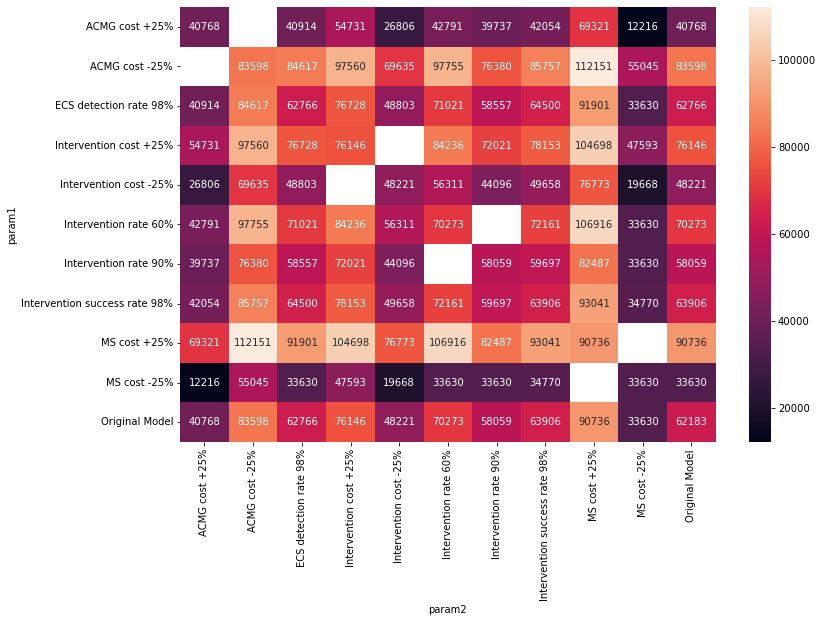

In [23]:
# A1 vs D


intervention_cost = 19714
rho_notint = 0.23
MS_cost = dl.strategy_dict['Strategy A1 (MS)'].testing_cost
ACMG_cost = dl.strategy_dict['Strategy D (ACMG)'].testing_cost

strategy1 = 'Strategy A1 (MS)'
strategy2 = 'Strategy D (ACMG)'

param_list = [
             ('testing_cost1',0.75*MS_cost,'MS cost -25%'),
              ('testing_cost1',1.25*MS_cost,'MS cost +25%'),
                 ('testing_cost2',0.75*ACMG_cost,'ACMG cost -25%'),
              ('testing_cost2',1.25*ACMG_cost,'ACMG cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

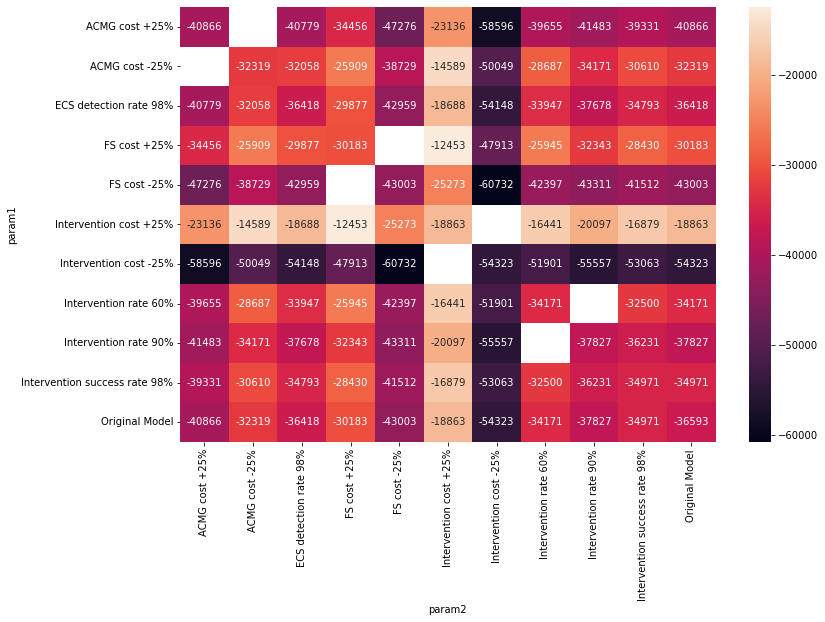

In [24]:
# A2 vs D


intervention_cost = 19714
rho_notint = 0.23
FS_cost = dl.strategy_dict['Strategy A2 (FS)'].testing_cost
ACMG_cost = dl.strategy_dict['Strategy D (ACMG)'].testing_cost

strategy1 = 'Strategy A2 (FS)'
strategy2 = 'Strategy D (ACMG)'

param_list = [
             ('testing_cost1',0.75*FS_cost,'FS cost -25%'),
              ('testing_cost1',1.25*FS_cost,'FS cost +25%'),
                 ('testing_cost2',0.75*ACMG_cost,'ACMG cost -25%'),
              ('testing_cost2',1.25*ACMG_cost,'ACMG cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

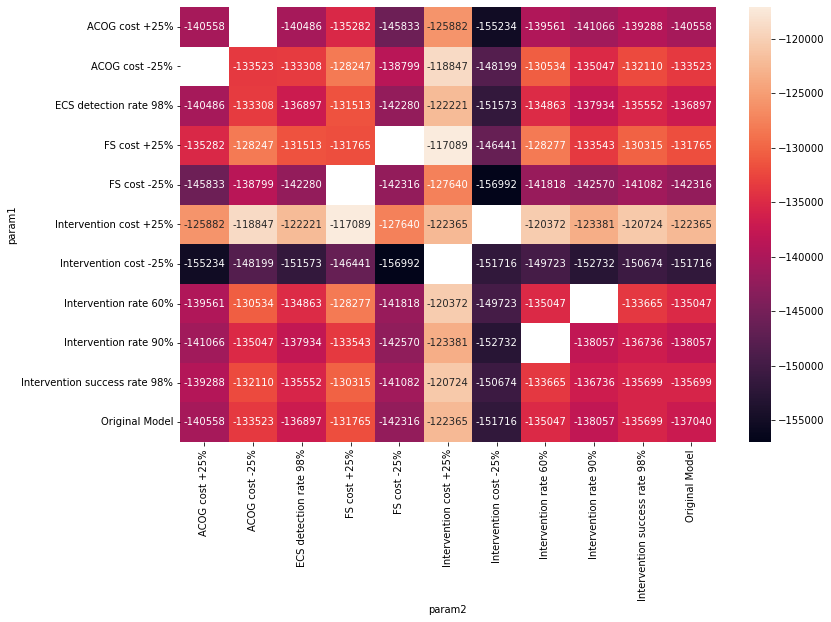

In [25]:
# A2 vs C


intervention_cost = 19714
rho_notint = 0.23
FS_cost = dl.strategy_dict['Strategy A2 (FS)'].testing_cost
ACOG_cost = dl.strategy_dict['Strategy C (ACOG)'].testing_cost

strategy1 = 'Strategy A2 (FS)'
strategy2 = 'Strategy C (ACOG)'

param_list = [
             ('testing_cost1',0.75*FS_cost,'FS cost -25%'),
              ('testing_cost1',1.25*FS_cost,'FS cost +25%'),
                 ('testing_cost2',0.75*ACOG_cost,'ACOG cost -25%'),
              ('testing_cost2',1.25*ACOG_cost,'ACOG cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

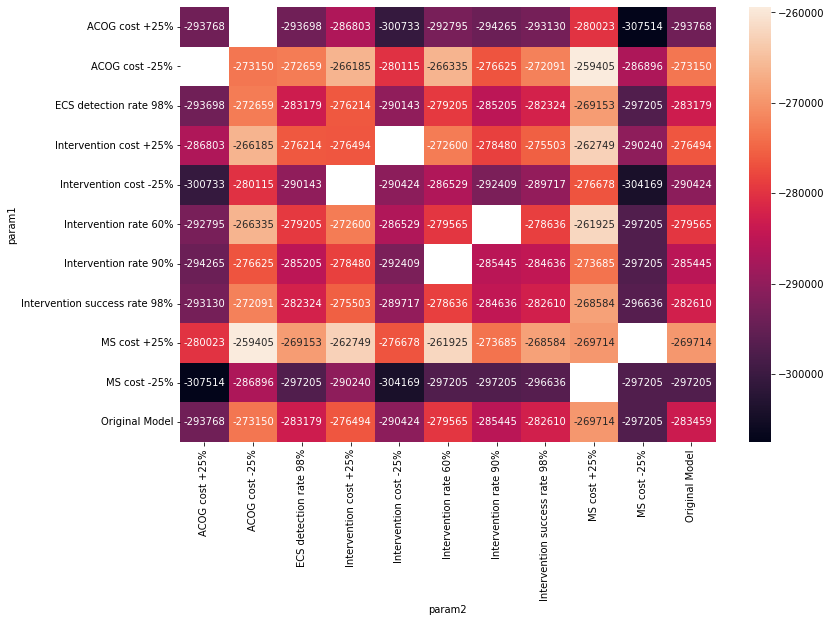

In [26]:
# A1 vs C


intervention_cost = 19714
rho_notint = 0.23
MS_cost = dl.strategy_dict['Strategy A1 (MS)'].testing_cost
ACOG_cost = dl.strategy_dict['Strategy C (ACOG)'].testing_cost

strategy1 = 'Strategy A1 (MS)'
strategy2 = 'Strategy C (ACOG)'

param_list = [
             ('testing_cost1',0.75*MS_cost,'MS cost -25%'),
              ('testing_cost1',1.25*MS_cost,'MS cost +25%'),
                 ('testing_cost2',0.75*ACOG_cost,'ACOG cost -25%'),
              ('testing_cost2',1.25*ACOG_cost,'ACOG cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

# Probabilistic analysis

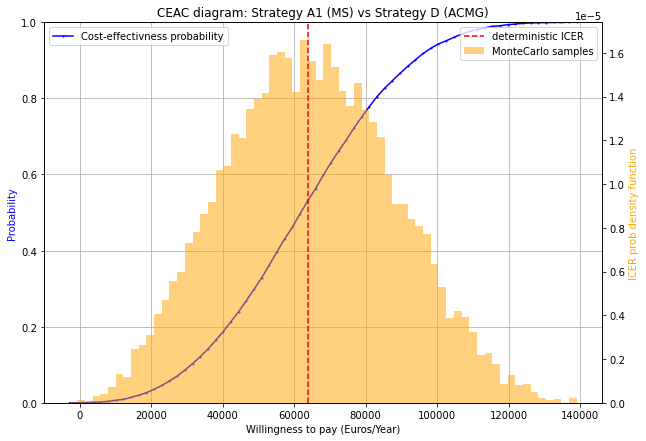

In [27]:
intervention_cost = 19714
AMCG_cost = dl.strategy_dict['Strategy D (ACMG)'].testing_cost

strategy1 = 'Strategy A1 (MS)'
strategy2 = 'Strategy D (ACMG)'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*MS_cost, testing_cost1_ub=1.25*MS_cost,
        testing_cost2_lb=0.75*AMCG_cost, testing_cost2_ub=1.25*AMCG_cost,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)



outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')

psa.plot_ceac_hist(outfile=outfile)

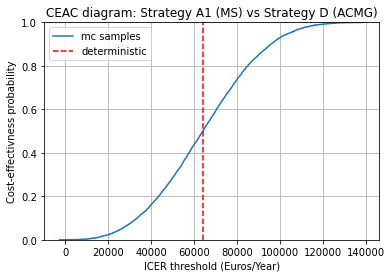

In [28]:
psa.plot_ceac()